<a href="https://colab.research.google.com/github/maddysshaw/Cognitive_AI_2024/blob/main/Coursework2c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. (c)
Using the same models, train them to solve a second task from NeuroGym, and
analyse them as in b). Do your conclusions from b) hold for this second task? [20 marks]

In [1]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Vanilla RNN

In [2]:
class VanillaRNN(nn.Module):
    """Vanilla RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """
    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
         # If hidden is a tuple (e.g., in LSTMs), unpack it
        if isinstance(hidden, tuple):
            hidden = hidden[0]  # Or hidden[1] depending on your RNN structure
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propagate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model using Vanilla RNN.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Vanilla RNN
        self.rnn = VanillaRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

# Feedback-Aligned RNN

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedbackAlignedRNN(nn.Module):
    """Feedback-aligned Vanilla RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """
    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define forward weights
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Define fixed random feedback weights
        self.feedback_weights = nn.Parameter(torch.randn(hidden_size, hidden_size), requires_grad=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step."""
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propagate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack outputs from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class FARNN(nn.Module):
    """Feedback-Aligned RNN.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Feedback-Aligned RNN
        self.rnn = FeedbackAlignedRNN(input_size, hidden_size, **kwargs)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Feedback weights for the output layer
        self.output_feedback_weights = nn.Parameter(torch.randn(output_size, hidden_size), requires_grad=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

    def feedback_alignment_update(self, optimizer, output, target):
        """Custom backward pass using feedback alignment."""
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)

        # Compute gradients for the output layer
        output_grad = torch.autograd.grad(loss, output, create_graph=True)[0]

        # Update output layer weights using fixed feedback weights
        with torch.no_grad():
            self.fc.weight.grad = torch.mm(output_grad, self.output_feedback_weights).t()
            self.fc.bias.grad = output_grad.sum(dim=0)

        # Compute gradients for RNN hidden weights using feedback weights
        for i in reversed(range(output.size(0))):
            hidden_grad = torch.mm(output_grad, self.rnn.feedback_weights)
            for param in self.rnn.parameters():
                if param.requires_grad:
                    param.grad = torch.autograd.grad(output[i], param, grad_outputs=hidden_grad, retain_graph=True)[0]

        # Apply optimizer step
        optimizer.step()
        optimizer.zero_grad()

# Excitatory-Inhibitory RNN

In [4]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math

class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        mask_no_diag = torch.ones(hidden_size, hidden_size) - torch.eye(hidden_size)
        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)
        exc = np.ones(self.e_size)
        inh = -np.ones(self.i_size)
        E_I_unit_list = np.concatenate((exc, inh)).T

        mask = mask_no_diag * E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class EINet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

Importing the Delayed Match-to-Sample Task from Neurogym

In [5]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 8.15 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793131 sha256=7c701f521f197d3dbb15505be4c2a27ecd9e99e18642ea63db4e0406a36b0b4f
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existin

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


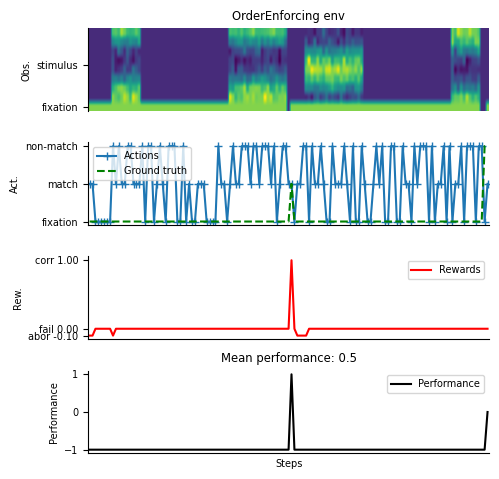

In [6]:
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# Environment
task = 'DelayMatchSample-v0'
rewards = {'correct': +1, 'incorrect': 0}
timing = {
    'fixation':(100, 200), # phase where agent is required to focus
    'sample': (200, 400),    # stimulus presented, agent must encode it
    'delay':  (400, 600),      # agent holds the sample information in memory
    'test':  (200, 400),     # new stimulus presented, agent decides if it matches sample
    'choice': (100,200),
}
#sigma = 0.5 # moderate observation noise
#dim_ring = 8 # stimulus represented on an 8-dimensional ring
kwargs = {
    'dt': 20,
    'timing': timing,
    'sigma': 0.5,
    'dim_ring': 8,
}
seq_len = 150 # longer sequence length due to delay period

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
#dms_env = dms_dataset.env
env = ngym.make(task, **kwargs)

# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

# Model Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float32)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Vanilla RNN Learning Curve on Task 2")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RNNNet(
  (rnn): VanillaRNN(
    (input2h): Linear(in_features=9, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.4593
Step 400, Loss 0.2999
Step 600, Loss 0.2857
Step 800, Loss 0.2789
Step 1000, Loss 0.2760


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
fa_net = FARNN(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(fa_net)

# Use Adam optimizer
optimizer = optim.Adam(fa_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

fa_loss_values = []  # List to store loss values
fa_running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float32)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = fa_net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    fa_running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = fa_running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        fa_loss_values.append(average_loss)  # Append average loss here
        fa_running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Feedback Aligned RNN Learning Curve on Task 2")
plt.plot(fa_loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
ei_net = EINet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(ei_net)

# Use Adam optimizer
optimizer = optim.Adam(ei_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

ei_loss_values = []  # List to store loss values
ei_running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float32)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = ei_net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    ei_running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = ei_running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        ei_loss_values.append(average_loss)  # Append average loss here
        ei_running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("EI RNN Learning Curve on Task 2")
plt.plot(ei_loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(env.trial['ground_truth'])


2


In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'sample': ('constant', 500),
                   'delay': ('constant', 500),
                   'test': ('constant', 500)})
def record_neural_activity(model, env, title_suffix=''):

  perf = 0
  num_trial = 500
  activity_dict = {}
  trial_infos = {}
  stim_activity = [[], []]  # response for ground-truth 1 and 2

#def record_neural_activity(model, env, title_suffix=''):
  for i in range(num_trial):
      env.new_trial()
      ob, gt = env.ob, env.gt
      inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
      action_pred, rnn_activity = model(inputs)

      # Compute performance
      action_pred = action_pred.detach().numpy()
      choice = np.argmax(action_pred[-1, 0, :])
      correct = choice == gt[-1]

      # Log trial info
      trial_info = env.trial
      trial_info.update({'correct': correct, 'choice': choice})
      trial_infos[i] = trial_info

      # Log stimulus period activity
      rnn_activity = rnn_activity[:, 0, :].detach().numpy()
      activity_dict[i] = rnn_activity

      # Compute stimulus selectivity for all units
      # Compute each neuron's response in trials where ground_truth=1 and 2 respectively
      rnn_activity = rnn_activity[env.start_ind['sample']: env.end_ind['sample']]
      ground_truth = env.trial['ground_truth']
       # Map ground truth to index in stim_activity
      index = ground_truth - 1  # Ground truth 1 → index 0, ground truth 2 → index 1
      if 0 <= index < len(stim_activity):
          stim_activity[index].append(rnn_activity)
      else:
          print(f"Warning: Invalid ground truth value {ground_truth} on trial {i}, skipping.")


  print(f'Average performance of {title_suffix}', np.mean([val['correct'] for val in trial_infos.values()]))

  return rnn_activity, action_pred, trial_infos, activity_dict, stim_activity
  #print(f'Average performance of {title_suffix}', np.mean([val['correct'] for val in trial_infos.values()]))

rnn_activity, action_pred, trial_infos, activity_dict, stim_activity = record_neural_activity(net, env, title_suffix='Vanilla RNN')
fa_rnn_activity, fa_action_pred, fa_trial_infos, fa_activity_dict, fa_stim_activity = record_neural_activity(fa_net, env, title_suffix='Feedback-Aligned RNN')
ei_rnn_activity, ei_action_pred, ei_trial_infos, ei_activity_dict, ei_stim_activity = record_neural_activity(ei_net, env, title_suffix='Excitatory-Inhibitory RNN')

In [ ]:
print(activity_dict[2].shape)
print(fa_activity_dict[2].shape)
print(ei_activity_dict[2].shape)
print(action_pred.shape)
print(fa_action_pred.shape)
print(ei_action_pred.shape)
print(trial_infos[2])
print(fa_trial_infos[2])
print(ei_trial_infos[2])

(145, 50)
(145, 50)
(145, 50)
(145, 1, 3)
(145, 1, 3)
(145, 1, 3)
{'ground_truth': 2, 'sample_theta': 5.497787143782138, 'test_theta': 2.356194490192344, 'correct': True, 'choice': 2}
{'ground_truth': 1, 'sample_theta': 4.71238898038469, 'test_theta': 4.71238898038469, 'correct': False, 'choice': 2}
{'ground_truth': 1, 'sample_theta': 0.7853981633974483, 'test_theta': 0.7853981633974483, 'correct': True, 'choice': 1}


In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = ei_net.rnn.e_size
input_size = net.rnn.hidden_size
fa_input_size = fa_net.rnn.hidden_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :input_size], color='purple', label='All Neurons')
plt.title('Vanilla RNN Neural Activity from Sample Trials')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure()
_ = plt.plot(fa_activity_dict[trial][:, :fa_input_size], color='orange', label='All Neurons')
plt.title('Feedback-Aligned RNN Neural Activity from Sample Trials')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure()
_ = plt.plot(ei_activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(ei_activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.title('Excitatory-Inhibitory RNN Neural Activity from Sample Trials')
plt.xlabel('Time step')
plt.ylabel('Activity')

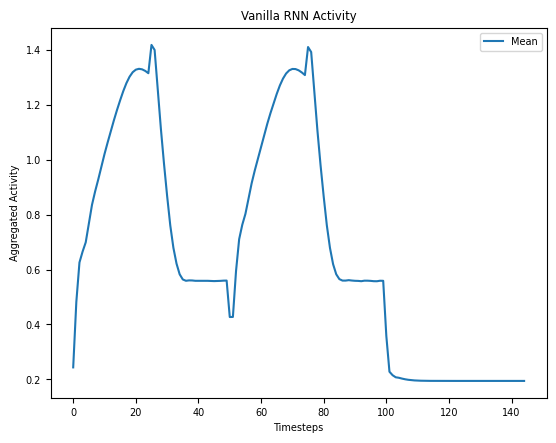

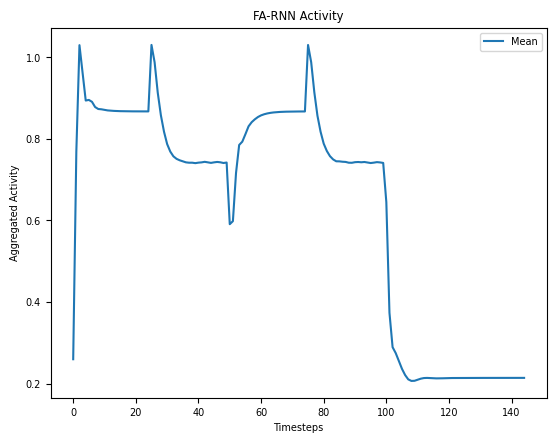

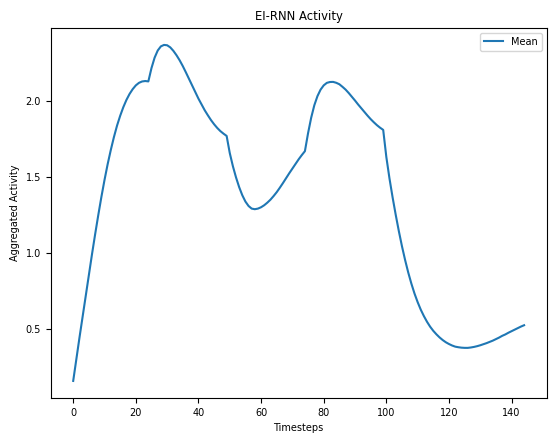

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hidden_activity(activity_dict, title="Hidden Activity (Aggregated)", aggregation='mean'):
    # Initialize a list to store aggregated activity for each trial
    aggregated_trials = []

    for trial, activity in activity_dict.items():
        # Aggregate activity across neurons (axis=1) for the current trial
        if aggregation == 'mean':
            aggregated_activity = np.mean(activity, axis=1)  # Mean across neurons
        elif aggregation == 'median':
            aggregated_activity = np.median(activity, axis=1)  # Median across neurons
        else:
            raise ValueError("Invalid aggregation method. Choose 'mean' or 'median'.")

        aggregated_trials.append(aggregated_activity)

    # Convert to a numpy array of shape (num_trials, timesteps)
    aggregated_trials = np.array(aggregated_trials)

    # Average across trials (axis=0)
    avg_aggregated_activity = np.mean(aggregated_trials, axis=0)

    mean_aggregated = np.mean(aggregated_trials, axis=0)
    median_aggregated = np.median(aggregated_trials, axis=0)

    plt.plot(mean_aggregated, label="Mean")
   # plt.plot(median_aggregated, label="Median")
    plt.xlabel("Timesteps")
    plt.ylabel("Aggregated Activity")
    plt.title(title)
    plt.legend()
    plt.show()

plot_hidden_activity(activity_dict, title="Vanilla RNN Activity", aggregation='mean')
plot_hidden_activity(fa_activity_dict, title="FA-RNN Activity", aggregation='mean')
plot_hidden_activity(ei_activity_dict, title="EI-RNN Activity", aggregation='mean')

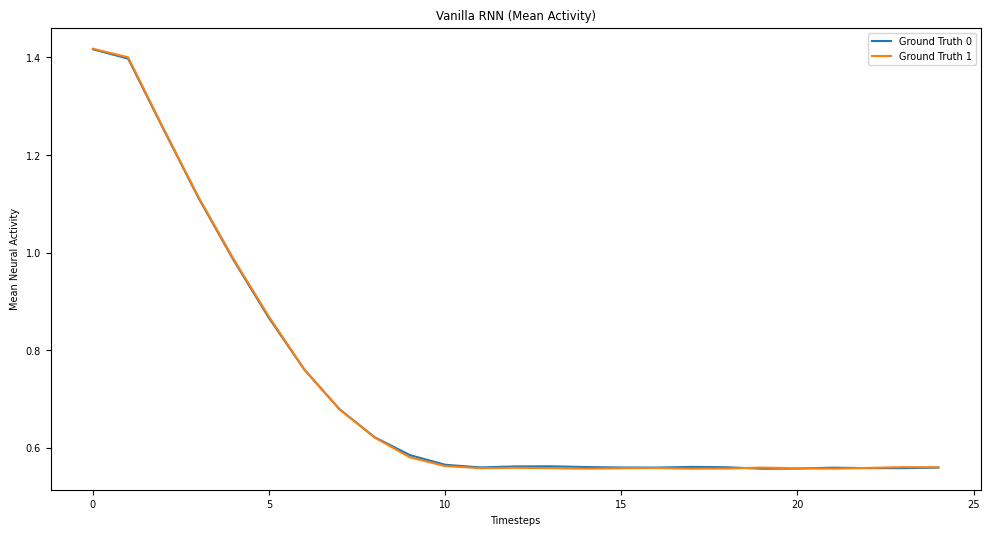

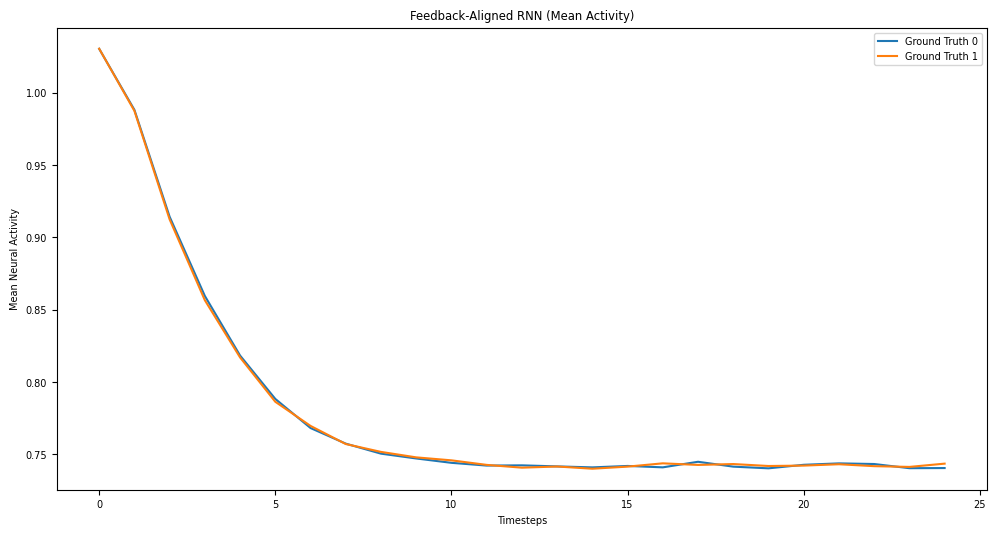

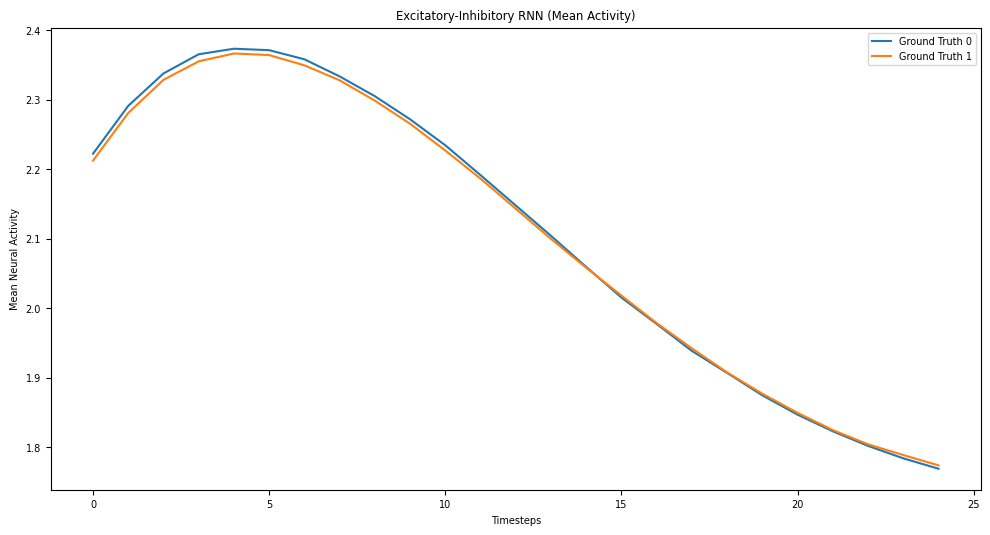

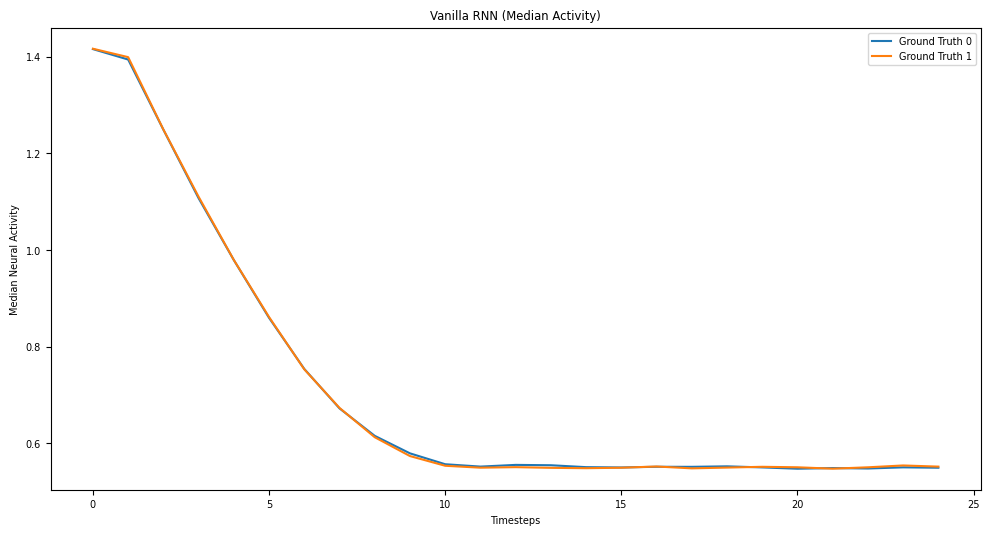

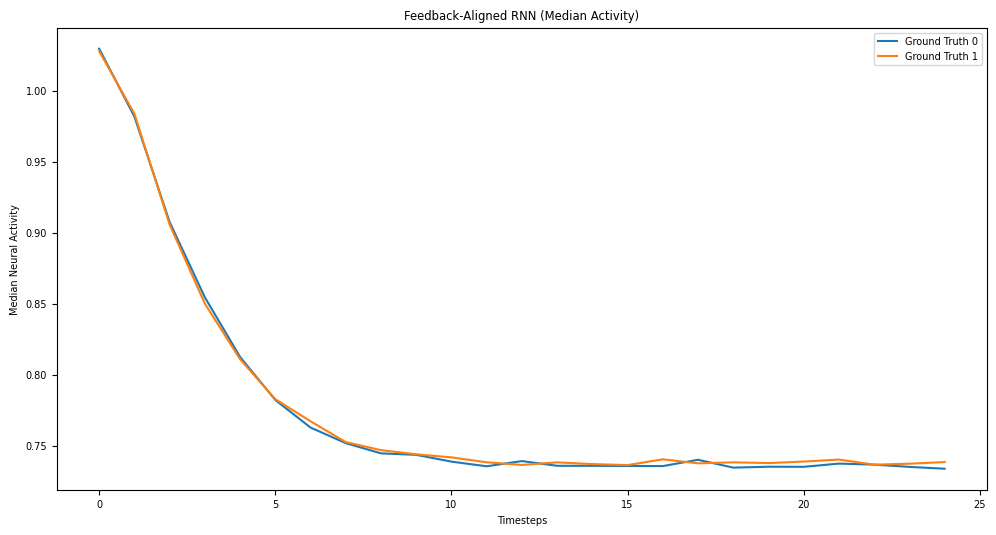

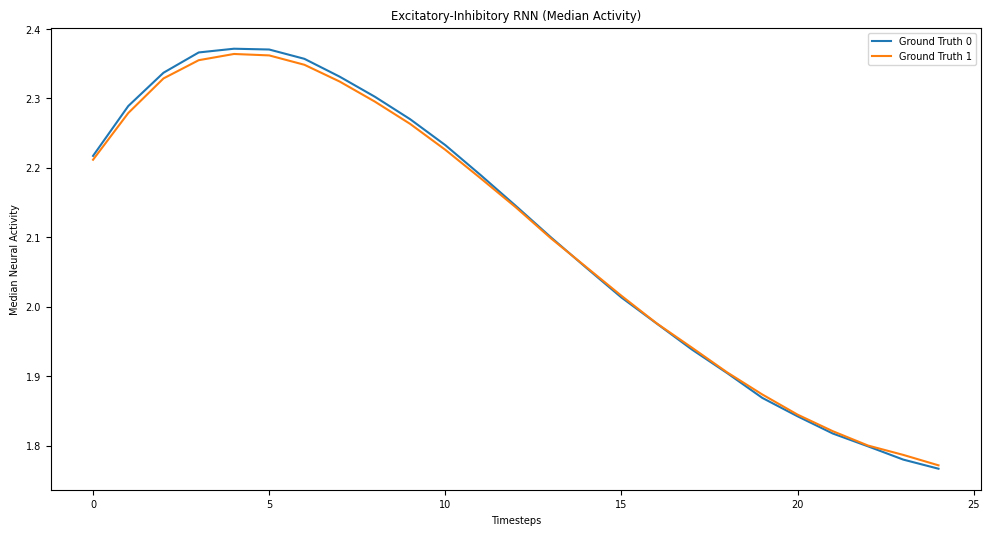

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_activity(stim_activity, title, summary_type="mean"):
    """
    Compute and plot the mean or median activity for each ground truth category.

    Args:
        stim_activity (list of lists): Neural activity grouped by ground truth.
        title (str): Title for the plot.
        summary_type (str): "mean" or "median", determines which summary statistic to compute.
    """
    num_categories = len(stim_activity)  # Number of ground truth categories
    summary_activity = []

    for category in range(num_categories):
        # Stack activity across trials for this ground truth category
        activity = np.stack(stim_activity[category], axis=0)  # Shape: (num_trials, num_timesteps, num_neurons)

        # Compute the summary statistic
        if summary_type == "mean":
            summary = np.mean(activity, axis=0)  # Average across trials
        elif summary_type == "median":
            summary = np.median(activity, axis=0)  # Median across trials
        else:
            raise ValueError(f"Invalid summary_type: {summary_type}")

        summary_activity.append(summary)

    # Plot the results
    plt.figure(figsize=(12, 6))
    for category, summary in enumerate(summary_activity):
        # Summary shape: (num_timesteps, num_neurons)
        mean_activity = np.mean(summary, axis=1)  # Average across neurons for visualization
        plt.plot(mean_activity, label=f'Ground Truth {category}')

    plt.title(f'{title} ({summary_type.capitalize()} Activity)')
    plt.xlabel('Timesteps')
    plt.ylabel(f'{summary_type.capitalize()} Neural Activity')
    plt.legend()
    plt.show()


# Compute and plot mean activity
plot_activity(stim_activity, title="Vanilla RNN", summary_type="mean")
plot_activity(fa_stim_activity, title="Feedback-Aligned RNN", summary_type="mean")
plot_activity(ei_stim_activity, title="Excitatory-Inhibitory RNN", summary_type="mean")

# Compute and plot median activity
plot_activity(stim_activity, title="Vanilla RNN", summary_type="median")
plot_activity(fa_stim_activity, title="Feedback-Aligned RNN", summary_type="median")
plot_activity(ei_stim_activity, title="Excitatory-Inhibitory RNN", summary_type="median")

In [ ]:
# @title Compute Stimulus Selectivity for sorting neurons
# Here for each neuron we compute its stimulus period selectivity

def compute_selectivity(model, activity_dict, trial_infos, stim_activity):
  if model == ei_net:
    input_size = ei_net.rnn.e_size
  else:
    input_size = model.rnn.hidden_size
  #input_size = model.rnn.input_size
  #fa_input_size = fa_net.rnn.input_size
  #input_size = net.rnn.input_size

  mean_activity = []
  std_activity = []
  for ground_truth in [0, 1]:
      activity = np.concatenate(stim_activity[ground_truth], axis=0)
      mean_activity.append(np.mean(activity, axis=0))
      std_activity.append(np.std(activity, axis=0))

  # Compute d'
  selectivity = (mean_activity[0] - mean_activity[1])
  selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

  if model == ei_net:
  # Sort index for selectivity, separately for E and I
    ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                               np.argsort(selectivity[e_size:])+e_size))
  else:
    ind_sort = np.argsort(selectivity)

  return selectivity, ind_sort

selectivity, ind_sort = compute_selectivity(net, activity_dict, trial_infos, stim_activity)
fa_selectivity, fa_ind_sort = compute_selectivity(fa_net, fa_activity_dict, fa_trial_infos, fa_stim_activity)
ei_selectivity, ei_ind_sort = compute_selectivity(ei_net, ei_activity_dict, ei_trial_infos, ei_stim_activity)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def plot_connectivity(model, selectivity):
  # Plot distribution of stimulus selectivity
  plt.figure()
  plt.hist(selectivity)
  plt.xlabel('Selectivity')
  plt.ylabel('Number of neurons')

  if model == ei_net:
    W = model.rnn.h2h.effective_weight().detach().numpy()
  else:
    W = model.rnn.h2h.weight.detach().numpy()
  # Sort by selectivity
  W = W[:, ind_sort][ind_sort, :]
  wlim = np.max(np.abs(W))
  plt.figure()
  plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
  plt.colorbar()
  plt.xlabel('From neurons')
  plt.ylabel('To neurons')
  plt.title('Network connectivity')
plot_connectivity(net, selectivity)
plot_connectivity(fa_net, fa_selectivity)
plot_connectivity(ei_net, ei_selectivity)

In [ ]:
# @title lesion top 20% of connections
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2  # Example: Lesion top 20% of neurons

def lesion_network(model, selectivity):
  if model == ei_net:
    input_size = ei_net.rnn.e_size
  else:
    input_size = model.rnn.hidden_size
  num_neurons_to_lesion = int(lesion_fraction * input_size)  # Lesion top 20% most selective neurons
  selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

  # Lesion function: Set weights to zero for selected neurons
  #def lesion_network(net, selective_neurons):
  with torch.no_grad():  # Ensure no gradients are recorded for this modification
          # Set input and output weights of the selected neurons to zero
          net.rnn.h2h.weight[:, selective_neurons] = 0
          net.rnn.h2h.weight[selective_neurons, :] = 0

  # Save initial weights for resetting after experiment
  initial_weights = net.rnn.h2h.weight.clone()

  # Lesion the network
  #lesion_network(model, selective_neurons)

  # Re-run the training/evaluation to observe the impact of lesioning on performance
  loss_values_lesioned = []  # List to store loss values post-lesioning
  running_loss_lesioned = 0.0

  print('Evaluating network after lesioning top 20% of neurons...')
  for i in range(300):  # Fewer steps to evaluate effect
      inputs, labels = dataset()
      inputs = torch.from_numpy(inputs).type(torch.float)
      labels = torch.from_numpy(labels.flatten()).type(torch.long)

      # Zero the gradient buffers
      optimizer.zero_grad()

      # Forward pass
      output, activity = model(inputs)
      output = output.view(-1, output_size)

      # Compute loss
      loss = criterion(output, labels)

      # Update running loss
      running_loss_lesioned += loss.item()
      if i % print_step == (print_step - 1):
          average_loss = running_loss_lesioned / print_step
          print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
          loss_values_lesioned.append(average_loss)  # Append average loss here
          running_loss_lesioned = 0.0

  # Reset weights after lesioning to original state
  net.rnn.h2h.weight = nn.Parameter(initial_weights)

lesion_network(net, selectivity)
lesion_network(fa_net, fa_selectivity)
lesion_network(ei_net, ei_selectivity)

Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.3707
Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.2708
Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.2724


Performing PCA for the Vanilla RNN...
Shape of the neural activity (Time points, Neurons) for Vanilla RNN: (72500, 50)
Shape of the projected activity (Time points, PCs) for Vanilla RNN: (72500, 2)


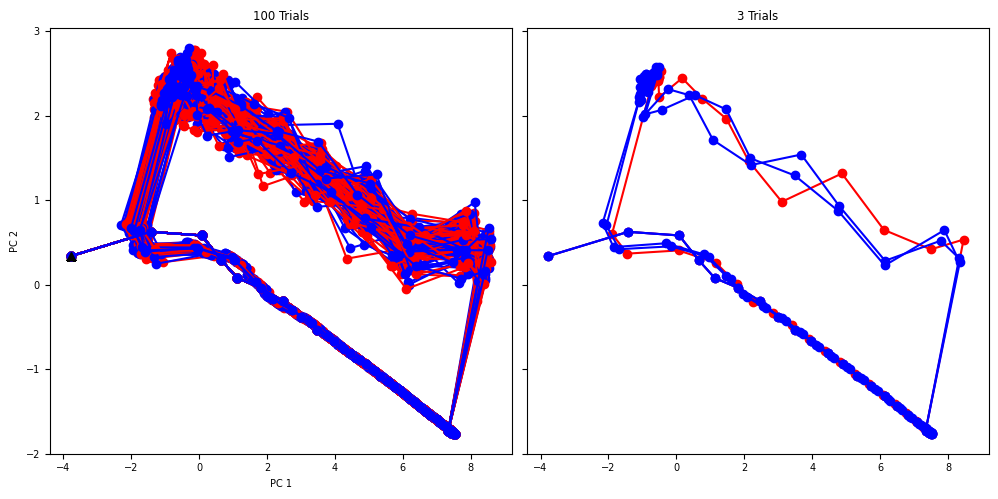

Performing PCA for the Feedback-Aligned RNN...
Shape of the neural activity (Time points, Neurons) for Feedback-Aligned RNN: (72500, 50)
Shape of the projected activity (Time points, PCs) for Feedback-Aligned RNN: (72500, 2)


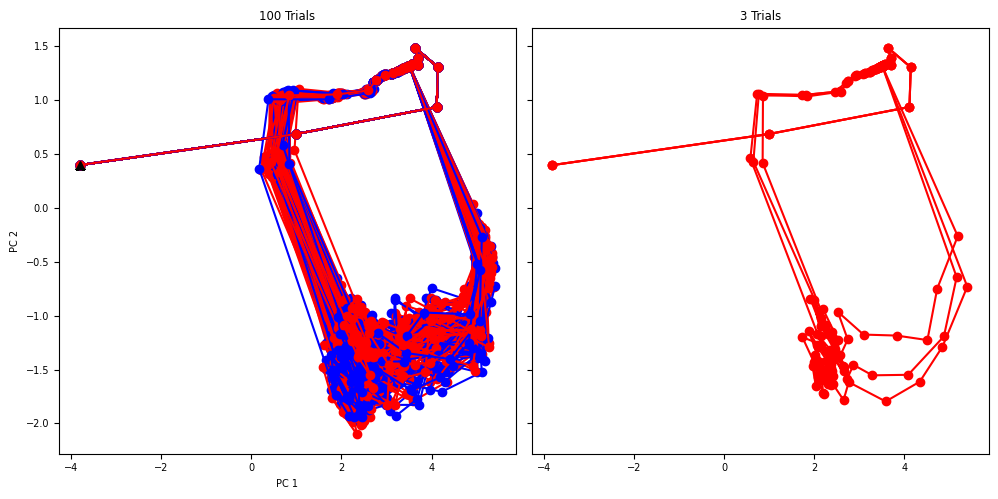

Performing PCA for the Excitatory-Inhibitory RNN...
Shape of the neural activity (Time points, Neurons) for Excitatory-Inhibitory RNN: (72500, 50)
Shape of the projected activity (Time points, PCs) for Excitatory-Inhibitory RNN: (72500, 2)


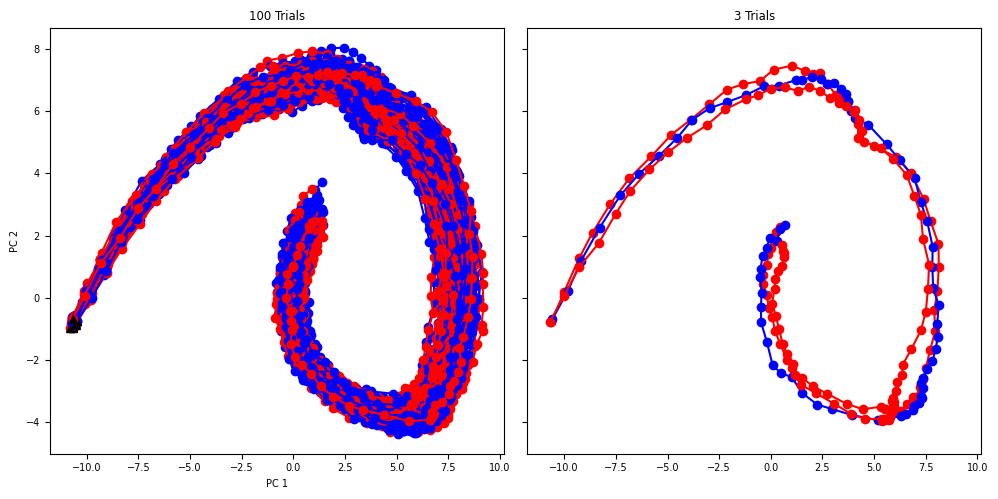

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 70


def pca_analysis(activity_dict, trial_infos, title_suffix=''):
  # Concatenate activity data across all trials for PCA
  activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
  # print('Shape of the neural activity (Time points, Neurons):', activity.shape)
  print(f'Shape of the neural activity (Time points, Neurons) for {title_suffix}:', activity.shape)

  # Initialize PCA and fit it on the activity data
  pca = PCA(2)  # Using 2 components for visualization
  pca.fit(activity)
  activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D) - hint ".transform" could he helpful
  print(f'Shape of the projected activity (Time points, PCs) for {title_suffix}:', activity_pc.shape)

  # Visualization
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

  # Plot all trials in ax1 and fewer trials in ax2 for clarity
  for i in range(100):
      # Transform and plot each trial
      activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

      # Color by ground truth
      trial = trial_infos[i]
      color = 'red' if trial['ground_truth'] == 1 else 'blue'

      ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
      if i < 3:  # Fewer trials in ax2 for clear visualization
          ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

      # Indicate trial start with a different marker
      ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

  # Setting labels and titles for clarity
  ax1.set_title('100 Trials')
  ax2.set_title('3 Trials')
  ax1.set_xlabel('PC 1')
  ax1.set_ylabel('PC 2')

  plt.tight_layout()
  plt.show()

print("Performing PCA for the Vanilla RNN...")
pca_analysis(activity_dict, trial_infos, title_suffix='Vanilla RNN')

print("Performing PCA for the Feedback-Aligned RNN...")
pca_analysis(fa_activity_dict, fa_trial_infos, title_suffix='Feedback-Aligned RNN')

print("Performing PCA for the Excitatory-Inhibitory RNN...")
pca_analysis(ei_activity_dict, ei_trial_infos, title_suffix='Excitatory-Inhibitory RNN')

# good to change the number of timepoints you visualise to see variation and potential trends over time

# Finding Fixed Points

In [ ]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master

# Install required dependencies from the requirements file
!pip install -r requirements-torch

# Install dependencies
!pip install numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1

unzip:  cannot find or open /content/fixed-point-finder-master.zip, /content/fixed-point-finder-master.zip.zip or /content/fixed-point-finder-master.zip.ZIP.
[Errno 2] No such file or directory: '/content/fixed-point-finder-master'
/content/neurogym/neurogym
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements-torch'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 846.6 kB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attemp

In [ ]:
!git clone https://github.com/mattgolub/fixed-point-finder

Cloning into 'fixed-point-finder'...
remote: Enumerating objects: 1049, done.
remote: Counting objects: 100% (370/370), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 1049 (delta 263), reused 315 (delta 227), pack-reused 679 (from 1)
Receiving objects: 100% (1049/1049), 603.31 KiB | 9.00 MiB/s, done.
Resolving deltas: 100% (646/646), done.


In [ ]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN

In [ ]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0) if hidden.dim() == 3 else hidden

        # Preserve the original structure of hidden
        original_hidden_structure = hidden

        # If hidden is a tuple, concatenate or select the first element
        if isinstance(hidden, tuple):
            hidden = torch.cat(hidden, dim=-1) if len(hidden) > 1 else hidden[0]

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Restore the original structure of hidden
        if isinstance(original_hidden_structure, tuple):
            # Assuming original_hidden_structure had two elements
            # Adjust this logic if your original hidden has a different structure
            hidden_size = original_hidden_structure[0].shape[-1]
            hidden = (hidden[:, :hidden_size], hidden[:, hidden_size:]) #split hidden back
        else:
           # If original_hidden_structure was not a tuple, we keep hidden as is.
           pass

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [ ]:
def access_fixed_points(model):

  input_size = model.rnn.input_size
  # Instantiate the FixedPointRNNWrapper with the model
  rnn_model_fixed_point = FixedPointRNNWrapper(model.rnn, batch_first=False)

  # Instantiate FixedPointFinder with the wrapped EI-RNN model
  finder = FixedPointFinder(rnn_model_fixed_point)

  # Define initial conditions and inputs for fixed-point analysis
  initial_conditions = torch.randn(10, model.rnn.hidden_size)  # 10 random initial hidden states (one for each hidden unit)
  inputs = torch.zeros(10, input_size)  # Zero input for each initial condition

  # Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
  init_hidden_np = initial_conditions.cpu().numpy()
  inputs_np = inputs.cpu().numpy()

  # Find fixed points (CHeck FixedPointFinder documentation)
  fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

  # Unpack the returned tuple
  fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

  # Access fixed points
  fixed_points = fps.xstar  # Now you can access the xstar attribute
  return fixed_points

fixed_points = access_fixed_points(net)
fa_fixed_points = access_fixed_points(fa_net)
ei_fixed_points = access_fixed_points(ei_net)


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		297 iters
		q = 5.69e-13 +/- 9.46e-14
		dq = 1.37e-13 +/- 1.14e-13
		learning rate = 9.50e-01
		avg iter time = 9.60e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		461 iters
		q = 2.85e-13 +/- 2.36e-13
		dq = 1.06e-13 +/- 7.46e-14
		learning r

ValueError: too many values to unpack (expected 2)

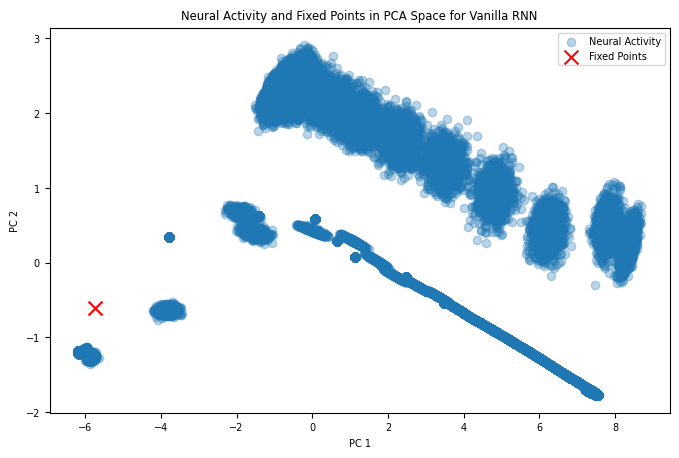

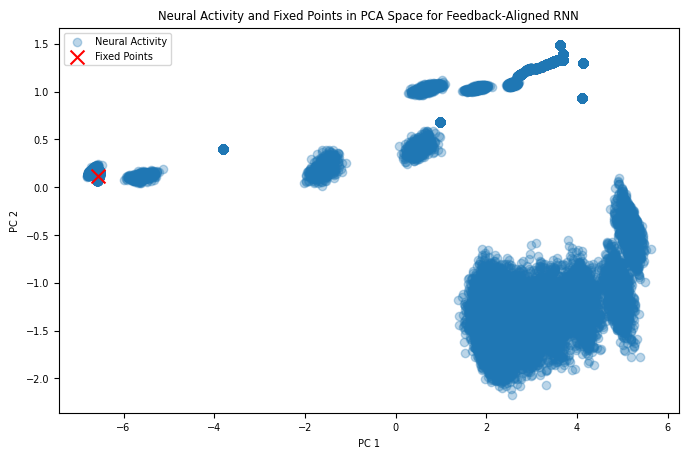

NameError: name 'ei_fixed_points' is not defined

In [ ]:
def plot_fixed_points(activity_dict, fixed_points, title_suffix=''):
  # Collect activity from all trials
  activity_list = []
  for trial_activity in activity_dict.values():
      activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
  activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

  # Convert fixed points list to numpy array if it's not already
  fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

  # Apply PCA to project fixed points and neural activity into the same space
  from sklearn.decomposition import PCA
  import matplotlib.pyplot as plt

  pca = PCA(n_components=2)
  # Concatenate activity and fixed points for PCA projection
  activity_and_fp = np.concatenate([activity, fixed_points], axis=0)
  pca.fit(activity_and_fp)

  # Transform activity and fixed points
  activity_pc = pca.transform(activity)
  fixed_points_pc = pca.transform(fixed_points)

  # Plot activity and fixed points
  plt.figure(figsize=(8, 5))
  plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
  plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
  plt.xlabel("PC 1")
  plt.ylabel("PC 2")
  plt.title(f"Neural Activity and Fixed Points in PCA Space for {title_suffix}")
  plt.legend()
  plt.show()

plot_fixed_points(activity_dict, fixed_points, title_suffix='Vanilla RNN')
plot_fixed_points(fa_activity_dict, fa_fixed_points, title_suffix='Feedback-Aligned RNN')
plot_fixed_points(ei_activity_dict, ei_fixed_points, title_suffix='Excitatory-Inhibitory RNN')